# Instance

In [21]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class PDPTWInstance:
    def __init__(self, n, map_size, speed, extra_time,seed=None):
        """
        初始化 PDPTW 实例
        :param n: pickup 点的数量
        :param map_size: 地图大小
        :param speed: 车辆速度
        :param extra_time: delivery 点时间窗口起始时间的额外时间
        :param seed: 随机数种子
        """
        self.n = n
        self.map_size = map_size
        self.speed = speed
        self.extra_time = extra_time
        self.depot = (0, 0)  # depot 位于原点
        self.pickup_points = []  # pickup 点的坐标
        self.delivery_points = []  # delivery 点的坐标
        self.time_windows = []  # 时间窗口列表
        self.service_times = []  # 服务时间列表
        self.demands = []  # 需求量列表

        # 设置随机数种子
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        
        # 生成所有点的索引列表
        self.indices = [0] + list(range(1, self.n+1)) + list(range(self.n+1, 2*self.n+1))
        
        self.generate_points()  # 生成 pickup 和 delivery 点
        self.generate_time_windows()  # 生成时间窗口和服务时间
        self.generate_demands()  # 生成需求量

    def generate_points(self):
        """
        生成 pickup 和 delivery 点
        """
        for _ in range(self.n):
            # 在地图范围内随机生成 pickup 点坐标
            pickup_x = random.uniform(-self.map_size, self.map_size)
            pickup_y = random.uniform(-self.map_size, self.map_size)
            self.pickup_points.append((pickup_x, pickup_y))

            # 在地图范围内随机生成 delivery 点坐标
            delivery_x = random.uniform(-self.map_size, self.map_size)
            delivery_y = random.uniform(-self.map_size, self.map_size)
            self.delivery_points.append((delivery_x, delivery_y))

    def plot_instance(self):
        """
        绘制 PDPTW 实例图
        """
        plt.figure(figsize=(8, 8))
        # 绘制 depot
        plt.scatter(self.depot[0], self.depot[1], c='red', marker='s', s=100, label='Depot')
        # 绘制 pickup 点
        plt.scatter([p[0] for p in self.pickup_points], [p[1] for p in self.pickup_points], c='blue', marker='o', label='Pickup')
        # 绘制 delivery 点
        plt.scatter([d[0] for d in self.delivery_points], [d[1] for d in self.delivery_points], c='green', marker='d', label='Delivery')
        
        # 为每个点添加标签
        for i in range(self.n):
            plt.annotate(f'P{i+1}', (self.pickup_points[i][0], self.pickup_points[i][1]), textcoords='offset points', xytext=(0,5), ha='center')
            plt.annotate(f'D{i+1}', (self.delivery_points[i][0], self.delivery_points[i][1]), textcoords='offset points', xytext=(0,5), ha='center')

        # 设置坐标轴范围
        plt.xlim(-self.map_size-1, self.map_size+1)
        plt.ylim(-self.map_size-1, self.map_size+1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('PDPTW Instance')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def calculate_distance_matrix(self):
        """
        计算距离矩阵
        :return: 距离矩阵
        """
        points = [self.depot] + self.pickup_points + self.delivery_points
        num_points = len(points)
        distance_matrix = np.zeros((num_points, num_points))
        
        # 计算每对点之间的欧几里得距离
        for i in range(num_points):
            for j in range(num_points):
                distance_matrix[i][j] = np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
        
        return distance_matrix
    
    def calculate_time_matrix(self):
        """
        计算时间矩阵
        :return: 时间矩阵
        """
        distance_matrix = self.calculate_distance_matrix()
        time_matrix = (distance_matrix / self.speed)*60
        return time_matrix
    
    def generate_time_windows(self):
        """
        生成时间窗口和服务时间
        """
        time_matrix = self.calculate_time_matrix()
        
        # Depot 的时间窗口设置为 [0, inf]
        self.time_windows.append((0, float('inf')))
        
        for i in range(self.n):
            # Pickup 点的起始时间在 [0, 120] 范围内随机生成，结束时间设置为 inf
            start_time = random.randint(0, 120)
            self.time_windows.append((start_time, float('inf')))
            
            # Delivery 点的起始时间为对应 pickup 点的起始时间 + 时间矩阵中的时间 + 额外时间，向上取整
            # 结束时间为起始时间 + 30 分钟，向下取整
            delivery_start_time = math.ceil(start_time + time_matrix[0][i+1] + self.extra_time)
            delivery_end_time = math.floor(delivery_start_time + 30)
            self.time_windows.append((delivery_start_time, delivery_end_time))
            
            # 每个 pickup 点和 delivery 点的服务时间在 [5, 10] 范围内随机生成一个整数
            self.service_times.append(random.randint(5, 10))
            self.service_times.append(random.randint(5, 10))
        
        # Depot 的服务时间设置为 0
        self.service_times.append(0)
        
    def generate_demands(self):
        """
        生成需求量
        """
        # Depot 的需求量为 0
        self.demands.append(0)
        
        for _ in range(self.n):
            # Pickup 点的需求量为 1
            self.demands.append(1)
        for _ in range(self.n):
            # Delivery 点的需求量为 -1
            self.demands.append(-1)
            
    def to_dataframe(self):
        """
        将 PDPTW 实例转换为 pandas 数据框
        :return: pandas 数据框
        """
        data = []
        
        for i in range(len(self.indices)):
            if i == 0:
                point_type = 'd'
                x, y = self.depot
                partner_id = 0
            elif i <= self.n:
                point_type = 'cp'
                x, y = self.pickup_points[i-1]
                partner_id = i + self.n
            else:
                point_type = 'cd'
                x, y = self.delivery_points[i-self.n-1]
                partner_id = i - self.n
                
            data.append([
                i,
                point_type,
                x,
                y,
                self.demands[i],
                self.time_windows[i][0],
                self.time_windows[i][1],
                self.service_times[i],
                partner_id
            ])
        
        columns = ['ID', 'Type', 'X', 'Y', 'Demand', 'ReadyTime', 'DueDate', 'ServiceTime', 'PartnerID']
        df = pd.DataFrame(data, columns=columns)
        
        return df

## test

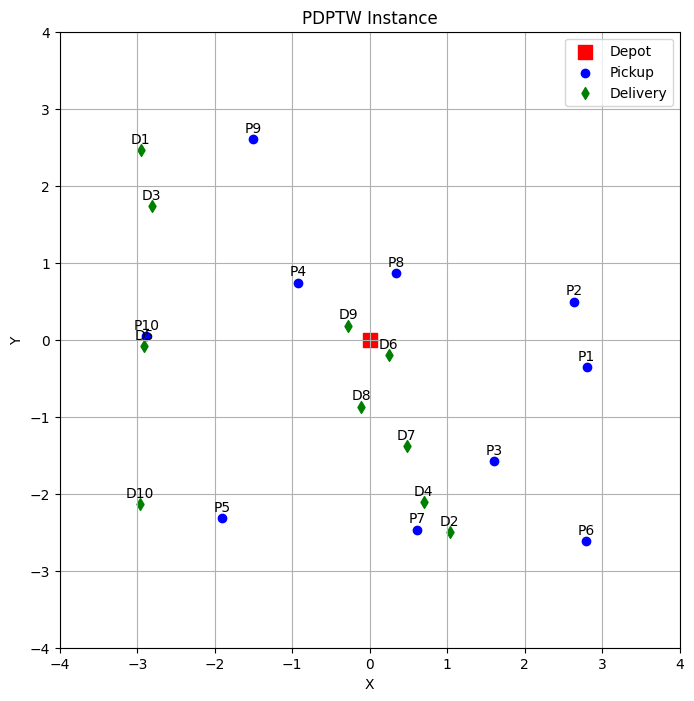

,ID,Type,X,Y,Demand,ReadyTime,DueDate,ServiceTime,PartnerID
0,0,d,0.000000,0.000000,0,0,inf,10,0
1,1,cp,2.798721,-0.355604,1,60,inf,8,11
2,2,cp,2.635614,0.493365,1,71,101.0,5,12
3,3,cp,1.598886,-1.579141,1,21,inf,5,13
4,4,cp,-0.923466,0.739689,1,32,62.0,8,14
5,5,cp,-1.901456,-2.313522,1,75,inf,6,15
6,6,cp,2.789409,-2.612626,1,86,116.0,9,16
7,7,cp,0.608781,-2.466427,1,9,inf,6,17
8,8,cp,0.338595,0.867805,1,20,50.0,5,18
9,9,cp,-1.505087,2.601093,1,18,inf,7,19


In [23]:
# 创建一个有5个pickup点，地图大小为10，车辆速度为1，额外时间为10的PDPTW实例
instance = PDPTWInstance(n=10, map_size=3, speed=4, extra_time=10,seed = 1234)

# 绘制实例图
instance.plot_instance()

# 将实例转换为 pandas 数据框
df = instance.to_dataframe()
df

# save and import

In [4]:
import pickle
# 将实例保存到文件
with open('pdptw_instance.pkl', 'wb') as file:
    pickle.dump(instance, file)

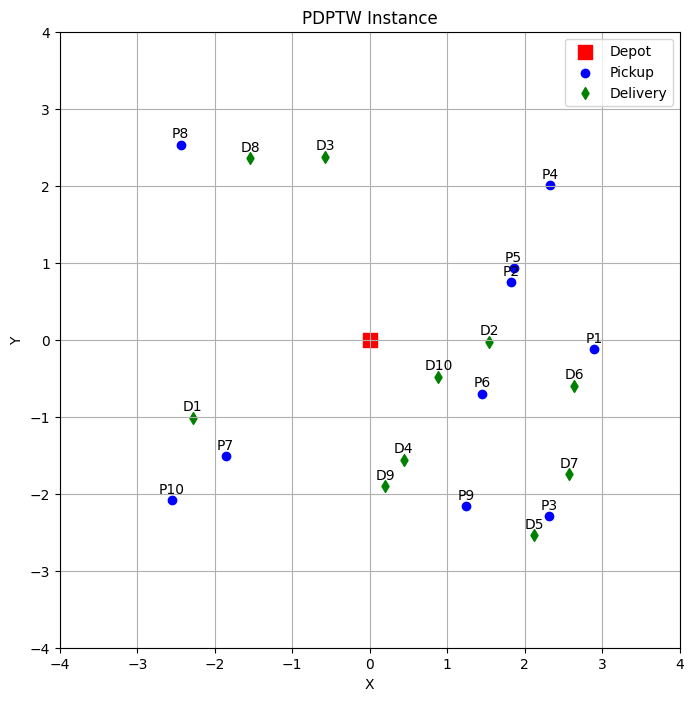

,ID,Type,X,Y,Demand,ReadyTime,DueDate,ServiceTime,PartnerID
0,0,d,0.000000,0.000000,0,0,inf,6,0
1,1,cp,2.892615,-0.120041,1,116,inf,6,11
2,2,cp,1.824285,0.746246,1,127,157.0,10,12
3,3,cp,2.318709,-2.293366,1,37,inf,10,13
4,4,cp,2.326336,2.007633,1,48,78.0,6,14
5,5,cp,1.854874,0.930956,1,77,inf,9,15
6,6,cp,1.449718,-0.702163,1,88,118.0,7,16
7,7,cp,-1.860107,-1.509176,1,114,inf,8,17
8,8,cp,-2.442063,2.531602,1,125,155.0,6,18
9,9,cp,1.244464,-2.164488,1,95,inf,7,19


In [5]:
# 从文件中加载 PDPTW 实例
with open('pdptw_instance.pkl', 'rb') as file:
    loaded_instance = pickle.load(file)

# 使用加载的实例
loaded_instance.plot_instance()
distance_matrix = loaded_instance.calculate_distance_matrix()
time_matrix = loaded_instance.calculate_time_matrix()
df = loaded_instance.to_dataframe()
df

# solution structure

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class PDPTWSolution:
    def __init__(self, instance, vehicle_capacity, battery_capacity, battery_consume_rate, routes):
        """
        初始化 PDPTWSolution 对象
        :param instance: PDPTWInstance 对象
        :param vehicle_capacity: 车辆容量
        :param battery_capacity: 电池容量
        :param battery_consume_rate: 电池消耗率
        :param routes: 给定的路径列表
        """
        self.instance = instance
        self.vehicle_capacity = vehicle_capacity
        self.battery_capacity = battery_capacity
        self.battery_consume_rate = battery_consume_rate
        self.routes = routes
        self.num_vehicles = len(routes)
        # battery and capacity
        self.route_battery_levels = np.empty((self.num_vehicles,), dtype=object)
        self.route_capacity_levels = np.empty((self.num_vehicles,), dtype=object)
        # time
        self.route_arrival_times = np.empty((self.num_vehicles,), dtype=object)
        self.route_leave_times = np.empty((self.num_vehicles,), dtype=object)
        self.route_wait_times = np.empty((self.num_vehicles,), dtype=object)
        # evaluation
        self.total_travel_times = np.zeros((self.num_vehicles,))
        self.total_delay_times = np.zeros((self.num_vehicles,))
        self.total_wait_times = np.zeros((self.num_vehicles,))

        self.initialize_routes()
        self.calculate_all()

    def initialize_routes(self):
        """
        初始化与路径相关的变量
        """
        for vehicle_id in range(self.num_vehicles):
            route = self.routes[vehicle_id]
            self.route_battery_levels[vehicle_id] = np.zeros((len(route),))
            self.route_capacity_levels[vehicle_id] = np.zeros((len(route),))
            self.route_arrival_times[vehicle_id] = np.zeros((len(route),))
            self.route_leave_times[vehicle_id] = np.zeros((len(route),))
            self.route_wait_times[vehicle_id] = np.zeros((len(route),))

    def calculate_all(self):
        """
        计算所有状态变量和目标函数值
        """
        for vehicle_id in range(self.num_vehicles):
            self.calculate_battery_capacity_levels(vehicle_id)
            self.calculate_arrival_leave_wait_times(vehicle_id)
            self.calculate_travel_delay_wait_times(vehicle_id)

    def calculate_battery_capacity_levels(self, vehicle_id):
        """
        计算指定车辆在路径上每个节点的电池电量和容量水平
        :param vehicle_id: 车辆 ID
        """
        route = self.routes[vehicle_id]
        battery_levels = self.route_battery_levels[vehicle_id]
        capacity_levels = self.route_capacity_levels[vehicle_id]
        distance_matrix = self.instance.calculate_distance_matrix()

        battery_levels[0] = self.battery_capacity
        capacity_levels[0] = 0

        for i in range(1, len(route)):
            prev_node = route[i - 1]
            curr_node = route[i]
            distance = distance_matrix[prev_node][curr_node]
            battery_levels[i] = battery_levels[i - 1] - distance * self.battery_consume_rate
            capacity_levels[i] = capacity_levels[i - 1] + self.instance.demands[curr_node]

    def calculate_arrival_leave_wait_times(self, vehicle_id):
        """
        计算指定车辆在路径上每个节点的到达时间、离开时间和等待时间
        :param vehicle_id: 车辆 ID
        """
        route = self.routes[vehicle_id]
        arrival_times = self.route_arrival_times[vehicle_id]
        leave_times = self.route_leave_times[vehicle_id]
        wait_times = self.route_wait_times[vehicle_id]
        time_matrix = self.instance.calculate_time_matrix()

        arrival_times[0] = 0
        wait_times[0] = 0
        leave_times[0] = self.instance.service_times[route[0]]

        for i in range(1, len(route)):
            prev_node = route[i - 1]
            curr_node = route[i]
            arrival_times[i] = leave_times[i - 1] + time_matrix[prev_node][curr_node]
            wait_times[i] = max(0, self.instance.time_windows[curr_node][0] - arrival_times[i])
            if arrival_times[i] > self.instance.time_windows[curr_node][0]:
                wait_times[i] = 0
            leave_times[i] = arrival_times[i] + wait_times[i] + self.instance.service_times[curr_node]

    def calculate_travel_delay_wait_times(self, vehicle_id):
        """
        计算指定车辆的总行驶时间、总延误时间和总等待时间
        :param vehicle_id: 车辆 ID
        """
        route = self.routes[vehicle_id]
        leave_times = self.route_leave_times[vehicle_id]
        wait_times = self.route_wait_times[vehicle_id]
        time_matrix = self.instance.calculate_time_matrix()

        travel_time = 0
        delay_time = 0
        wait_time = 0

        for i in range(len(route) - 1):
            curr_node = route[i]
            next_node = route[i + 1]
            travel_time += time_matrix[curr_node][next_node]
            
            if self.instance.time_windows[next_node][1] != float('inf'):
                delay_time += max(0, leave_times[i] - self.instance.time_windows[next_node][1])
            
            wait_time += wait_times[i]

        self.total_travel_times[vehicle_id] = travel_time
        self.total_delay_times[vehicle_id] = delay_time
        self.total_wait_times[vehicle_id] = wait_time

    def objective_function(self):
        """
        计算目标函数值
        :return: 目标函数值（总行驶时间 + 总延误时间）
        """
        return np.sum(self.total_travel_times) + np.sum(self.total_delay_times)

    def is_feasible(self):
        """
        检查解的可行性
        """
        selected_vehicles = self.get_selected_vehicles()
        if not selected_vehicles:
            return False
        if not self.check_capacity_constraint(selected_vehicles):
            return False
        if not self.check_battery_constraint(selected_vehicles):
            return False
        # if not self.check_unique_service(selected_vehicles):
        #     return False
        # if not self.check_depot_constraint(selected_vehicles):
        #     return False
        # if not self.check_pickup_delivery_order(selected_vehicles):
        #     return False
        return True

    def get_selected_vehicles(self):
        """
        获取被选择的车辆列表
        :return: 被选择的车辆 ID 列表
        """
        selected_vehicles = []
        for vehicle_id in range(self.num_vehicles):
            if self.routes[vehicle_id] is not None and len(self.routes[vehicle_id]) > 0:
                selected_vehicles.append(vehicle_id)
        return selected_vehicles

    def check_capacity_constraint(self, selected_vehicles):
        """
        检查容量约束
        :param selected_vehicles: 被选择的车辆 ID 列表
        """
        for vehicle_id in selected_vehicles:
            if np.any(self.route_capacity_levels[vehicle_id] > self.vehicle_capacity):
                return False
        return True

    def check_battery_constraint(self, selected_vehicles):
        """
        检查电池约束
        :param selected_vehicles: 被选择的车辆 ID 列表
        """
        for vehicle_id in selected_vehicles:
            if np.any(self.route_battery_levels[vehicle_id] < 0):
                return False
        return True

    def check_unique_service(self, selected_vehicles):
        """
        检查唯一服务约束
        :param selected_vehicles: 被选择的车辆 ID 列表
        """
        visited_nodes = set()
        for vehicle_id in selected_vehicles:
            route = self.routes[vehicle_id]
            for node in route:
                if node in visited_nodes:
                    return False
                visited_nodes.add(node)
        return True

    def check_depot_constraint(self, selected_vehicles):
        """
        检查车辆是否从车场出发并返回车场
        :param selected_vehicles: 被选择的车辆 ID 列表
        """
        for vehicle_id in selected_vehicles:
            route = self.routes[vehicle_id]
            if route[0] != 0 or route[-1] != 0:
                return False
        return True

    def check_pickup_delivery_order(self, selected_vehicles):
        """
        检查取货-送货顺序约束
        :param selected_vehicles: 被选择的车辆 ID 列表
        :return: True 如果取货-送货顺序约束满足，False 否则
        """
        for vehicle_id in selected_vehicles:
            route = self.routes[vehicle_id]
            visited_pickups = set()
            for node in route:
                if 1 <= node <= self.instance.n:
                    visited_pickups.add(node)
                elif self.instance.n < node <= 2 * self.instance.n:
                    if node - self.instance.n not in visited_pickups:
                        return False
        return True

    def plot_solution(self):
        """
        绘制解的路线图
        """
        selected_vehicles = self.get_selected_vehicles()
        if not selected_vehicles:
            print("No vehicle is selected in the solution.")
            return

        plt.figure(figsize=(8, 8))
        plt.scatter(self.instance.depot[0], self.instance.depot[1], c='red', marker='s', s=100, label='Depot')
        plt.scatter([p[0] for p in self.instance.pickup_points], [p[1] for p in self.instance.pickup_points], c='blue', marker='o', label='Pickup')
        plt.scatter([d[0] for d in self.instance.delivery_points], [d[1] for d in self.instance.delivery_points], c='green', marker='d', label='Delivery')

        # 为每个点添加标签
        plt.annotate('Depot', (self.instance.depot[0], self.instance.depot[1]), textcoords='offset points', xytext=(0, 10), ha='center')
        for i, pickup_point in enumerate(self.instance.pickup_points, start=1):
            plt.annotate(f'P{i}', (pickup_point[0], pickup_point[1]), textcoords='offset points', xytext=(0, 5), ha='center')
        for i, delivery_point in enumerate(self.instance.delivery_points, start=1):
            plt.annotate(f'D{i}', (delivery_point[0], delivery_point[1]), textcoords='offset points', xytext=(0, 5), ha='center')

        color_map = plt.cm.get_cmap('viridis', len(selected_vehicles))
        for i, vehicle_id in enumerate(selected_vehicles):
            route = self.routes[vehicle_id]
            color = color_map(i)
            
            route_points = [self.instance.depot] + [self.instance.pickup_points[node-1] if node <= self.instance.n else self.instance.delivery_points[node-self.instance.n-1] for node in route[1:-1]] + [self.instance.depot]
            route_x = [point[0] for point in route_points]
            route_y = [point[1] for point in route_points]
            
            plt.plot(route_x, route_y, color=color, linestyle='-', linewidth=1.5, alpha=0.8, label=f'Vehicle {vehicle_id+1}')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('PDPTW Solution')
        plt.legend()
        plt.grid(True)
        plt.show()

## test

C:\Users\du313\AppData\Local\Temp\ipykernel_12212\1134084471.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(selected_vehicles))


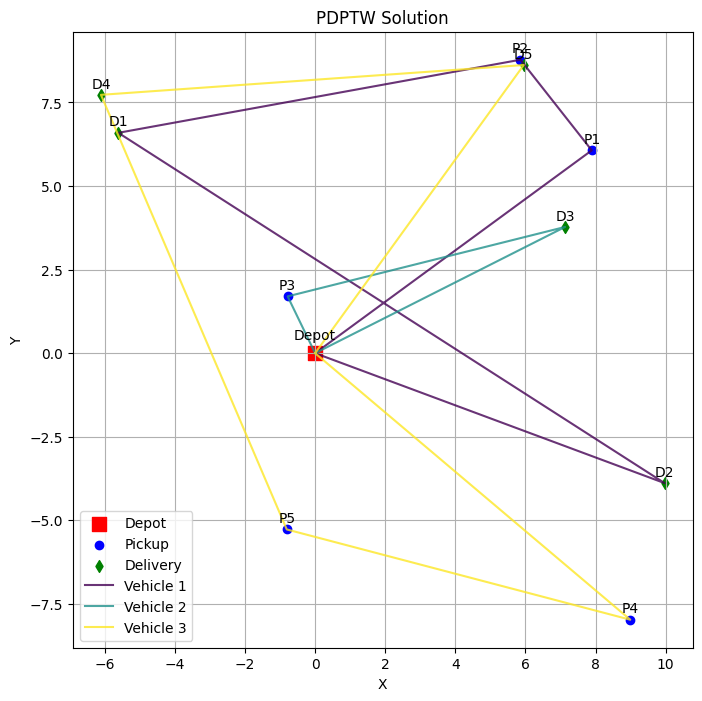

In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt

# 创建一个 PDPTWInstance 对象
instance = PDPTWInstance(n=5, map_size=10, speed=1, extra_time=10)

# 生成随机路径
num_vehicles = 3
routes = [[0,1,2,6,7,0],[0,3,8,0],[0,4,5,9,10,0]]

# 创建一个 PDPTWSolution 对象
vehicle_capacity = 10
battery_capacity = 240
battery_consume_rate = 1
solution = PDPTWSolution(instance, vehicle_capacity, battery_capacity, battery_consume_rate, routes)

# # 打印解的相关信息
# print("Routes:")
# print(solution.routes)
# print("Route Battery Levels:")
# print(solution.route_battery_levels)
# print("Route Capacity Levels:")
# print(solution.route_capacity_levels)
# print("Route Arrival Times:")
# print(solution.route_arrival_times)
# print("Route Leave Times:")
# print(solution.route_leave_times)
# print("Route Wait Times:")
# print(solution.route_wait_times)
# print("Total Travel Times:")
# print(solution.total_travel_times)
# print("Total Delay Times:")
# print(solution.total_delay_times)
# print("Total Wait Times:")
# print(solution.total_wait_times)
# print("Objective Function Value:")
# print(solution.objective_function())

# 绘制解的路线图
solution.plot_solution()

# initial solution

In [29]:
def greedy_insertion_init(instance, num_vehicles, vehicle_capacity, battery_capacity, battery_consume_rate):
    """
    使用贪心插入法构建初始解
    :param instance: PDPTWInstance 对象
    :param num_vehicles: 车辆数量
    :param vehicle_capacity: 车辆容量
    :param battery_capacity: 电池容量
    :param battery_consume_rate: 电池消耗率
    :return: 初始解
    """
    routes = []
    pickup_nodes = list(range(1, instance.n + 1))
    pickup_nodes.sort(key=lambda x: instance.time_windows[x][0])  # 按照 pickup 点的开始时间排序
    
    for vehicle_id in range(num_vehicles):
        route = [0, 0]

        while pickup_nodes:
            best_pickup_node = None
            best_insertion_index = None
            best_objective_value = float('inf')

            for pickup_node in pickup_nodes:
                delivery_node = pickup_node + instance.n
                for insertion_index in range(1,len(route)):
                    new_route = route
                    new_route = route[:insertion_index] + [pickup_node, delivery_node] + route[insertion_index:]
                    temp_solution = PDPTWSolution(instance, vehicle_capacity, battery_capacity, battery_consume_rate, [new_route])

                    if temp_solution.is_feasible():
                        objective_value = temp_solution.objective_function()
                        if objective_value < best_objective_value:
                            best_pickup_node = pickup_node
                            best_insertion_index = insertion_index
                            best_objective_value = objective_value

            if best_pickup_node is not None:
                pickup_nodes.remove(best_pickup_node)
                route = route[:best_insertion_index] + [best_pickup_node, best_pickup_node + instance.n] + route[best_insertion_index:]
            else:
                break
        
        routes.append(route)

    solution = PDPTWSolution(instance, vehicle_capacity, battery_capacity, battery_consume_rate, routes)
    return solution

## test

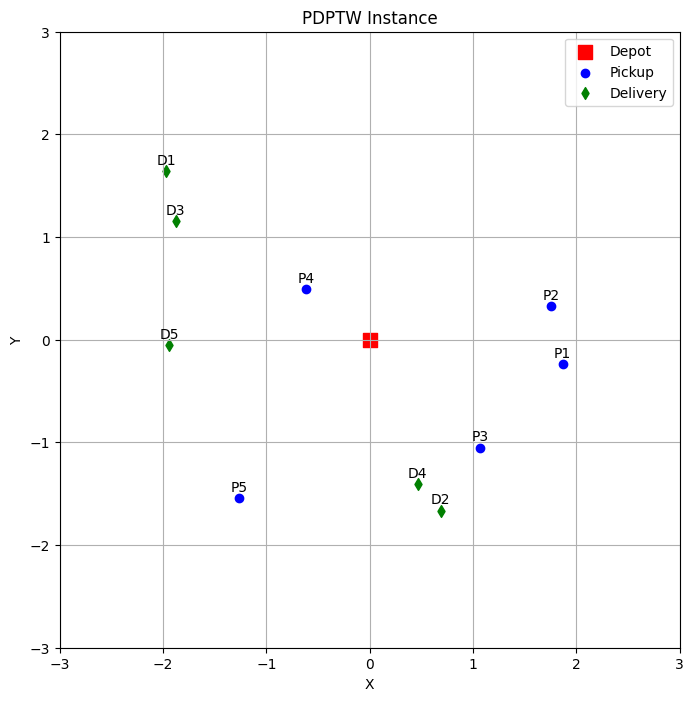

,ID,Type,X,Y,Demand,ReadyTime,DueDate,ServiceTime,PartnerID
0,0,d,0.000000,0.000000,0,0,inf,5,0
1,1,cp,1.865814,-0.237070,1,31,inf,10,6
2,2,cp,1.757076,0.328910,1,42,72.0,8,7
3,3,cp,1.065924,-1.052761,1,69,inf,5,8
4,4,cp,-0.615644,0.493126,1,80,110.0,10,9
5,5,cp,-1.267637,-1.542348,1,76,inf,5,10
6,6,cd,-1.970034,1.643904,-1,87,117.0,9,1
7,7,cd,0.686254,-1.664247,-1,65,inf,5,2
8,8,cd,-1.876744,1.155091,-1,76,106.0,9,3
9,9,cd,0.463263,-1.405781,-1,34,inf,5,4


In [30]:
instance = PDPTWInstance(n=5, map_size=2, speed=4, extra_time=10,seed = 1234)

instance.plot_instance()

df = instance.to_dataframe()
df

In [31]:
num_vehicles = 3
vehicle_capacity = 10
battery_capacity = 240
battery_consume_rate = 1
initial_solution = greedy_insertion_init(instance, num_vehicles, vehicle_capacity, battery_capacity, battery_consume_rate)

C:\Users\du313\AppData\Local\Temp\ipykernel_12212\1134084471.py:248: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(selected_vehicles))


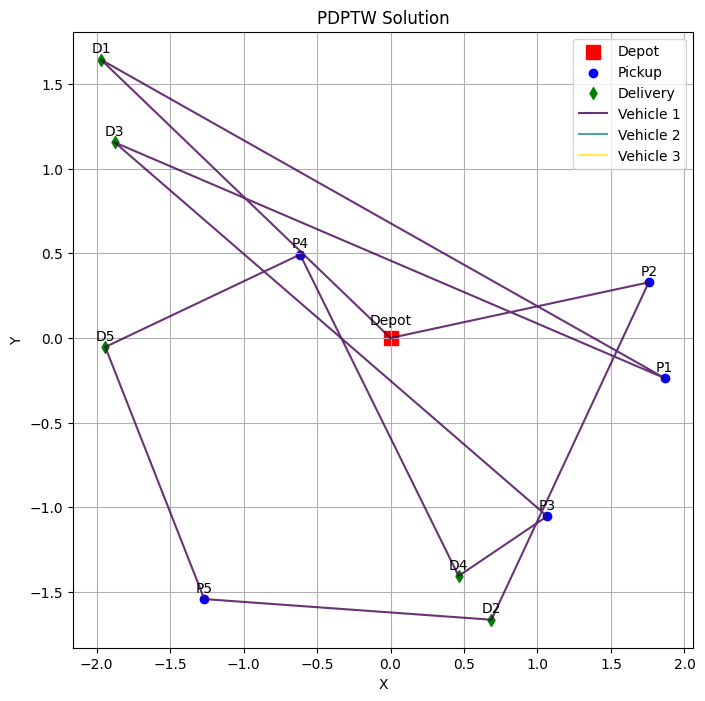

In [32]:
initial_solution.plot_solution()

In [33]:
initial_solution.routes

[[0, 2, 7, 5, 10, 4, 9, 3, 8, 1, 6, 0], [0, 0], [0, 0]]

In [36]:
instance.calculate_time_matrix()

array([[0.        , 0.47020371, 0.4468989 , 0.3745413 , 0.19719769,
        0.4991081 , 0.64145607, 0.45004603, 0.55093118, 0.37003664,
        0.48556199],
       [0.47020371, 0.        , 0.14408271, 0.28561085, 0.64666552,
        0.84861176, 1.06805293, 0.46288483, 0.99827512, 0.45641522,
        0.95294656],
       [0.4468989 , 0.14408271, 0.        , 0.38622425, 0.594599  ,
        0.88918851, 0.98807128, 0.56564876, 0.93163906, 0.54101225,
        0.9295664 ],
       [0.3745413 , 0.28561085, 0.38622425, 0.        , 0.57104271,
        0.59609161, 1.0151675 , 0.17994175, 0.91971131, 0.17461095,
        0.79231785],
       [0.19719769, 0.64666552, 0.594599  , 0.57104271, 0.        ,
        0.53433661, 0.44431563, 0.62994031, 0.35606971, 0.5460019 ,
        0.35848697],
       [0.4991081 , 0.84861176, 0.88918851, 0.59609161, 0.53433661,
        0.        , 0.81568847, 0.48942254, 0.69133873, 0.43406983,
        0.40867931],
       [0.64145607, 1.06805293, 0.98807128, 1.0151675 , 0.